✅ 成功加载字体: Microsoft YaHei

[阶段1] 正在读取数据...
✅ 数据加载成功！共 400000 行, 22 列。

[阶段2] 正在进行预处理与特征工程...
  [2.1] 修正 'Installation_Year' 并创建 'Machine_Age' 特征...
    发现并修正 145578 个无效安装年份，使用中位数 2012 填充。
    'Machine_Age' 特征已创建。
  [2.2] 对 'Last_Maintenance_Days_Ago' 进行特征分箱...
    'Maintenance_Bin' 特征已创建。
  [2.3] 创建交互特征...
    交互特征已创建。
  [2.4] 删除无用字段...
    已删除缺失值超过80%的列: ['Laser_Intensity', 'Hydraulic_Pressure_bar', 'Coolant_Flow_L_min', 'Heat_Index']
    已删除非特征列: ['Machine_ID', 'Remaining_Useful_Life_days', 'Installation_Year', 'Last_Maintenance_Days_Ago']
✅ 数据预处理与特征工程完成。特征数量: 18

[阶段3] 划分训练集与测试集...
✅ 数据划分完成。训练集样本数: 320000, 测试集样本数: 80000
  训练集故障比例: 6.04%, 测试集故障比例: 6.04%

[阶段4] 使用缩尾法（Winsorization）处理异常值...


  正在对数值列进行缩尾处理: 100%|██████████| 15/15 [00:00<00:00, 109.95it/s]


✅ 异常值处理完成。

[阶段5] 进行特征编码（独热编码）...
  识别到分类特征: ['Machine_Type', 'Maintenance_Bin']
✅ 特征编码完成。

[阶段6] 初始化 SMOTE 用于处理类别不平衡...
✅ SMOTE 初始化完成。将在交叉验证的每个折叠中应用。

[阶段7] 使用 Optuna 进行超参数调优（目标：最大化F1分数）...


  Optuna超参数搜索进度: 100%|██████████| 50/50 [19:10<00:00, 23.02s/it]



[结果] Optuna超参数调优完成。
  ✨ 最佳F1分数: 0.6532931910848075
  ✨ 最佳超参数： {'max_depth': 7, 'learning_rate': 0.0914304577237499, 'n_estimators': 960, 'subsample': 0.7696777057724238, 'colsample_bytree': 0.6627438699890655, 'gamma': 2.7942132006296716, 'reg_alpha': 0.001653540326724123, 'reg_lambda': 0.054561099510807405}

[阶段8] 使用最佳参数训练最终模型...
  开始训练最终XGBoost模型...
[0]	validation_0-logloss:0.62493
[1]	validation_0-logloss:0.56924
[2]	validation_0-logloss:0.61044
[3]	validation_0-logloss:0.57156
[4]	validation_0-logloss:0.52671
[5]	validation_0-logloss:0.48928
[6]	validation_0-logloss:0.45761
[7]	validation_0-logloss:0.43070
[8]	validation_0-logloss:0.40785
[9]	validation_0-logloss:0.38824
[10]	validation_0-logloss:0.37138
[11]	validation_0-logloss:0.35716
[12]	validation_0-logloss:0.34520
[13]	validation_0-logloss:0.34278
[14]	validation_0-logloss:0.33306
[15]	validation_0-logloss:0.34636
[16]	validation_0-logloss:0.33726
[17]	validation_0-logloss:0.34966
[18]	validation_0-logloss:0.35809
[19]	vali

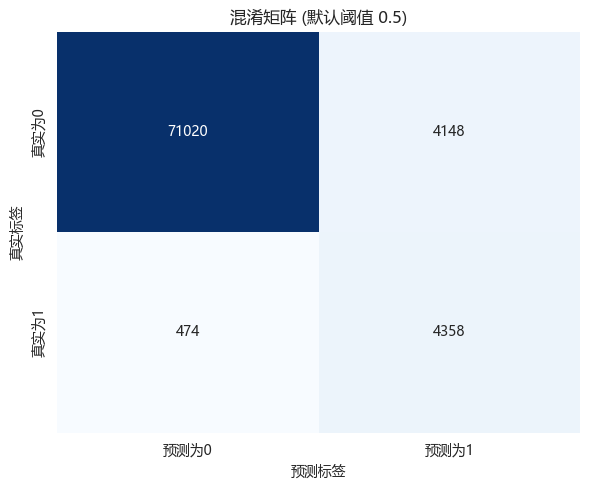

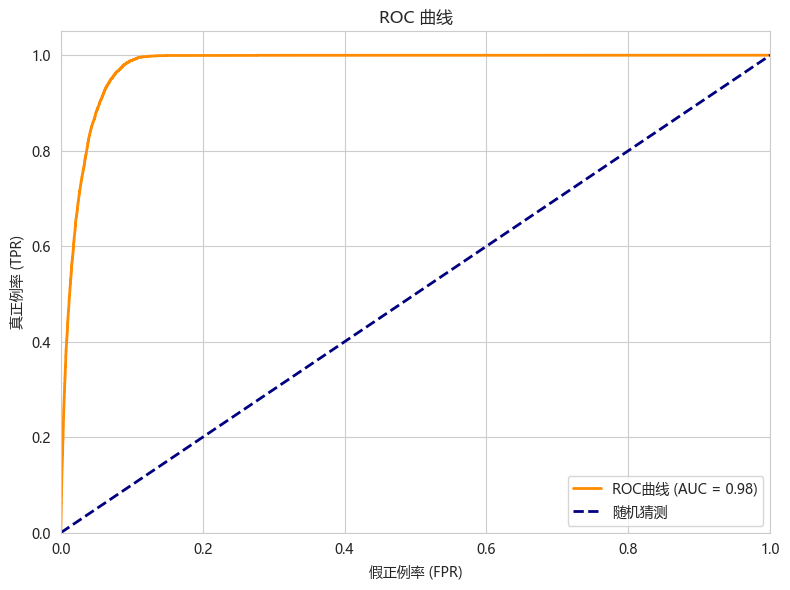


[阶段10] 特征重要性分析 (SHAP值)...


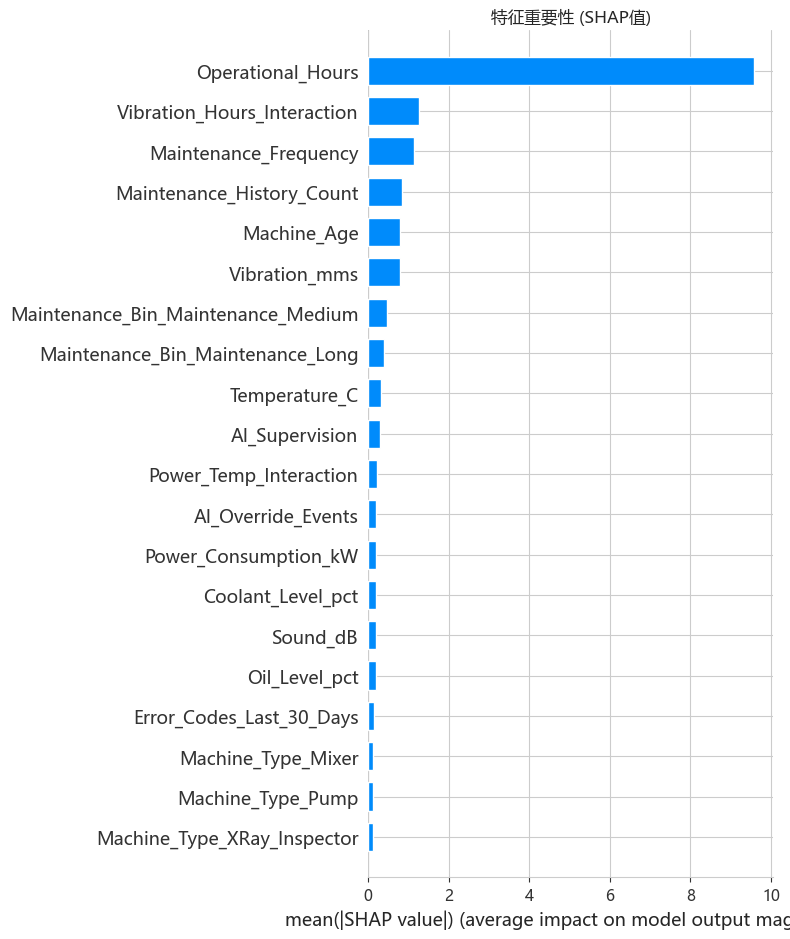

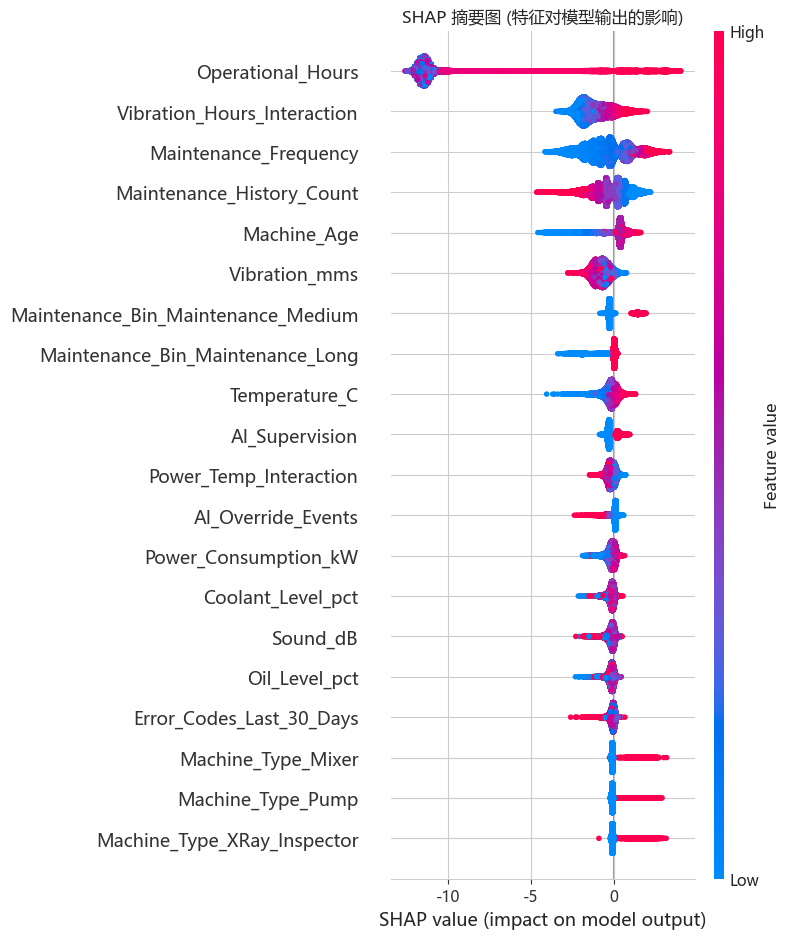


[阶段11] 阈值优化 (最大化召回率和F1分数)...
  --- 基于F1分数最大化的最佳阈值 ---
  最佳阈值 (F1): 0.751
  在该阈值下的F1分数: 0.6773
  在该阈值下的精确率: 0.5770
  在该阈值下的召回率: 0.8197

  --- 基于召回率最大化（精确率 > 0.5）的最佳阈值 ---
  最佳阈值 (Recall): 0.436
  在该阈值下的F1分数: 0.6465
  在该阈值下的精确率: 0.5000
  在该阈值下的召回率: 0.9145


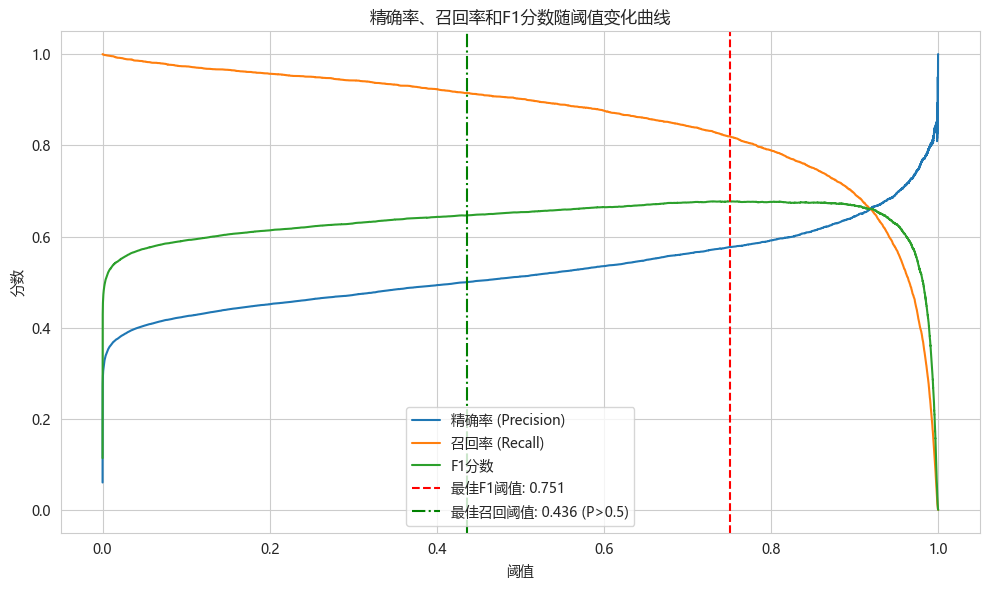


[结果] 选择最终使用的优化阈值：0.751 (此处选择F1分数最佳阈值)

--- 调整阈值后的模型评估 ---
  使用阈值: 0.751
分类报告：
               precision    recall  f1-score   support

       False       0.99      0.96      0.97     75168
        True       0.58      0.82      0.68      4832

    accuracy                           0.95     80000
   macro avg       0.78      0.89      0.83     80000
weighted avg       0.96      0.95      0.96     80000

混淆矩阵：
 [[72264  2904]
 [  871  3961]]


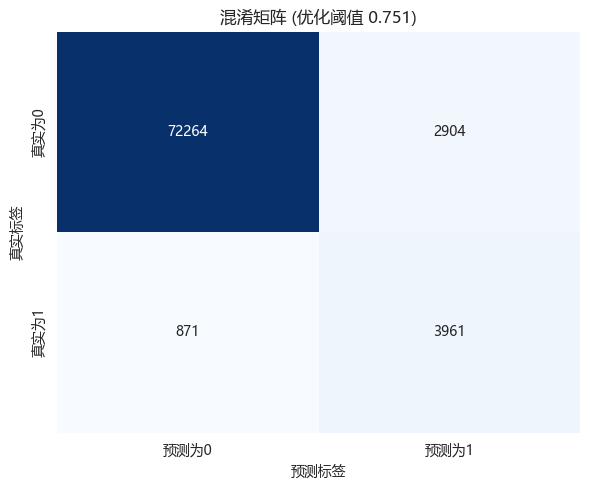


--- 分析完成 ---


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, roc_curve, precision_recall_curve
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import optuna
import shap
from tqdm import tqdm
import joblib
import matplotlib.font_manager as fm
import os

# ==================== 全局设置 ====================
# 清除 Matplotlib 缓存，强制重新加载字体
matplotlib_cache_dir = os.path.expanduser("~/.matplotlib")
if os.path.exists(matplotlib_cache_dir):
    for file in os.listdir(matplotlib_cache_dir):
        if file.startswith("fontList") and file.endswith((".json", ".cache")):
            os.remove(os.path.join(matplotlib_cache_dir, file))
            print(f"已删除 Matplotlib 缓存文件: {file}")

# 设置 Matplotlib 支持中文字符和负号
try:
    font_path = r"C:\Windows\Fonts\msyhl.ttc"  # 微软雅黑 UI 字体
    prop = fm.FontProperties(fname=font_path)
    plt.rcParams['font.family'] = prop.get_name()
    plt.rcParams['axes.unicode_minus'] = False
    print(f"✅ 成功加载字体: {prop.get_name()}")
except Exception as e:
    print(f"❌ 字体加载失败: {e}, 回退到默认设置")
    plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei']
    plt.rcParams['axes.unicode_minus'] = False
    print("  使用备用字体: SimHei 或 Microsoft YaHei")

# 设置 Seaborn 样式
sns.set_style("whitegrid")

# ==================== 1. 数据读取 ====================
print("\n[阶段1] 正在读取数据...")
file_path = r'D:\桌面\2025年第四届“创新杯”（原钉钉杯）大学生大数据挑战赛初赛题目\2025年第四届“创新杯”（原钉钉杯）大学生大数据挑战赛初赛题目\A题\data\train_data.csv'
try:
    df = pd.read_csv(file_path)
    print(f"✅ 数据加载成功！共 {df.shape[0]} 行, {df.shape[1]} 列。")
except FileNotFoundError:
    print(f"❌ 错误：文件未找到，请检查路径：{file_path}")
    exit()

# ==================== 2. 数据预处理与特征工程 ====================
print("\n[阶段2] 正在进行预处理与特征工程...")

# --- 2.1 修正 Installation_Year 并创建 Machine_Age ---
print("  [2.1] 修正 'Installation_Year' 并创建 'Machine_Age' 特征...")
REFERENCE_YEAR = 2025
invalid_years_mask = (df['Installation_Year'] > REFERENCE_YEAR) | (df['Installation_Year'] < 1980)
if invalid_years_mask.any():
    valid_years_median = df.loc[~invalid_years_mask, 'Installation_Year'].median()
    print(f"    发现并修正 {invalid_years_mask.sum()} 个无效安装年份，使用中位数 {valid_years_median:.0f} 填充。")
    df.loc[invalid_years_mask, 'Installation_Year'] = valid_years_median
df['Machine_Age'] = REFERENCE_YEAR - df['Installation_Year']
print("    'Machine_Age' 特征已创建。")

# --- 2.2 对 Last_Maintenance_Days_Ago 进行分箱 ---
print("  [2.2] 对 'Last_Maintenance_Days_Ago' 进行特征分箱...")
bins = [-1, 30, 90, np.inf]
labels = ['Maintenance_Recent', 'Maintenance_Medium', 'Maintenance_Long']
df['Maintenance_Bin'] = pd.cut(df['Last_Maintenance_Days_Ago'], bins=bins, labels=labels, right=True)
print("    'Maintenance_Bin' 特征已创建。")

# --- 2.3 创建交互特征 ---
print("  [2.3] 创建交互特征...")
df['Power_Temp_Interaction'] = df['Power_Consumption_kW'] * df['Temperature_C']
df['Vibration_Hours_Interaction'] = df['Vibration_mms'] * df['Operational_Hours']
df['Maintenance_Frequency'] = df['Maintenance_History_Count'] / (df['Machine_Age'] + 1)
print("    交互特征已创建。")

# --- 2.4 删除无用字段 ---
print("  [2.4] 删除无用字段...")
missing_ratio = df.isnull().mean()
high_missing_cols = missing_ratio[missing_ratio > 0.8].index.tolist()
if high_missing_cols:
    df.drop(columns=high_missing_cols, inplace=True)
    print(f"    已删除缺失值超过80%的列: {high_missing_cols}")
cols_to_drop = ['Machine_ID', 'Remaining_Useful_Life_days', 'Installation_Year', 'Last_Maintenance_Days_Ago']
df.drop(columns=cols_to_drop, errors='ignore', inplace=True)
print(f"    已删除非特征列: {cols_to_drop}")

# 分离特征和目标变量
y = df['Failure_Within_7_Days']
X = df.drop(columns=['Failure_Within_7_Days'])
print(f"✅ 数据预处理与特征工程完成。特征数量: {X.shape[1]}")

# ==================== 3. 数据划分 ====================
print("\n[阶段3] 划分训练集与测试集...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print(f"✅ 数据划分完成。训练集样本数: {X_train.shape[0]}, 测试集样本数: {X_test.shape[0]}")
print(f"  训练集故障比例: {y_train.sum()/len(y_train):.2%}, 测试集故障比例: {y_test.sum()/len(y_test):.2%}")

# ==================== 4. 异常值处理 ====================
print("\n[阶段4] 使用缩尾法（Winsorization）处理异常值...")
def winsorize_dataframes(X_train_df, X_test_df, lower=0.01, upper=0.99):
    X_train_processed = X_train_df.copy()
    X_test_processed = X_test_df.copy()
    numeric_cols = X_train_processed.select_dtypes(include=np.number).columns
    for col in tqdm(numeric_cols, desc="  正在对数值列进行缩尾处理"):
        if not X_train_processed[col].empty:
            lower_bound = X_train_processed[col].quantile(lower)
            upper_bound = X_train_processed[col].quantile(upper)
            X_train_processed[col] = np.clip(X_train_processed[col], lower_bound, upper_bound)
            X_test_processed[col] = np.clip(X_test_processed[col], lower_bound, upper_bound)
    return X_train_processed, X_test_processed
X_train, X_test = winsorize_dataframes(X_train, X_test)
print("✅ 异常值处理完成。")

# ==================== 5. 特征编码 ====================
print("\n[阶段5] 进行特征编码（独热编码）...")
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
if categorical_cols:
    print(f"  识别到分类特征: {categorical_cols}")
    X_train = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
    X_test = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)
    X_test = X_test.reindex(columns=X_train.columns, fill_value=0)
    print("✅ 特征编码完成。")
else:
    print("  未发现分类特征，跳过特征编码。")

# ==================== 6. 处理不平衡数据 ====================
print("\n[阶段6] 初始化 SMOTE 用于处理类别不平衡...")
smt = SMOTE(random_state=42)
print("✅ SMOTE 初始化完成。将在交叉验证的每个折叠中应用。")

# ==================== 7. 超参数调优 ====================
print("\n[阶段7] 使用 Optuna 进行超参数调优（目标：最大化F1分数）...")
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):
    params = {
        'max_depth': trial.suggest_int("max_depth", 3, 7),
        'learning_rate': trial.suggest_float("learning_rate", 0.005, 0.1),
        'n_estimators': trial.suggest_int("n_estimators", 100, 1000),
        'subsample': trial.suggest_float("subsample", 0.6, 1.0),
        'colsample_bytree': trial.suggest_float("colsample_bytree", 0.6, 1.0),
        'gamma': trial.suggest_float("gamma", 0, 5),
        'reg_alpha': trial.suggest_float("reg_alpha", 0.001, 10.0, log=True),
        'reg_lambda': trial.suggest_float("reg_lambda", 0.001, 10.0, log=True),
        'eval_metric': 'logloss',
        'random_state': 42,
        'n_jobs': -1,
        'tree_method': 'gpu_hist',
        'predictor': 'gpu_predictor',
        'verbosity': 0,
        'early_stopping_rounds': 50
    }
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    model = XGBClassifier(**params, scale_pos_weight=scale_pos_weight)
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    f1_scores = []
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        X_tr_res, y_tr_res = smt.fit_resample(X_tr, y_tr)
        model.fit(X_tr_res, y_tr_res, eval_set=[(X_val, y_val)], verbose=False)
        y_pred = model.predict(X_val)
        f1_scores.append(f1_score(y_val, y_pred))
    return np.mean(f1_scores)

study = optuna.create_study(direction="maximize", study_name="xgb_gpu_opt_f1")
with tqdm(total=50, desc="  Optuna超参数搜索进度") as pbar:
    study.optimize(objective, n_trials=50, callbacks=[lambda study, trial: pbar.update(1)])
best_params = study.best_params
print("\n[结果] Optuna超参数调优完成。")
print("  ✨ 最佳F1分数:", study.best_value)
print("  ✨ 最佳超参数：", best_params)

# ==================== 8. 训练最终模型 ====================
print("\n[阶段8] 使用最佳参数训练最终模型...")
final_model_params = best_params.copy()
final_model_params['scale_pos_weight'] = (y_train == 0).sum() / (y_train == 1).sum()
final_model_params['eval_metric'] = 'logloss'
final_model_params['tree_method'] = 'gpu_hist'
final_model_params['predictor'] = 'gpu_predictor'
final_model_params['random_state'] = 42
final_model_params['n_jobs'] = -1
final_model_params['verbosity'] = 1
final_model_params['early_stopping_rounds'] = 50

model = XGBClassifier(**final_model_params)
X_tr_final, X_val_final, y_tr_final, y_val_final = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)
X_tr_res_final, y_tr_res_final = smt.fit_resample(X_tr_final, y_tr_final)
print("  开始训练最终XGBoost模型...")
model.fit(X_tr_res_final, y_tr_res_final, eval_set=[(X_val_final, y_val_final)], verbose=True)
model_filename = 'xgboost_fault_prediction_model.pkl'
joblib.dump(model, model_filename)
print(f"✅ 模型已保存为 '{model_filename}'")

# ==================== 9. 模型评估 ====================
print("\n[阶段9] 模型评估...")
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]
print("\n--- 原始阈值（0.5）下的模型评估 ---")
print("分类报告：\n", classification_report(y_test, y_pred))
print("混淆矩阵：\n", confusion_matrix(y_test, y_pred))
print(f"ROC-AUC 分数：{roc_auc_score(y_test, y_pred_proba):.4f}")

# 绘制混淆矩阵（显式设置字体）
plt.figure(figsize=(6, 5))
plt.rcParams['font.family'] = fm.FontProperties(fname=font_path).get_name()  # 强制使用 msyhl.ttc
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['预测为0', '预测为1'], yticklabels=['真实为0', '真实为1'])
plt.title('混淆矩阵 (默认阈值 0.5)')
plt.xlabel('预测标签')
plt.ylabel('真实标签')
plt.tight_layout()
plt.show()

# 绘制ROC曲线（显式设置字体）
plt.figure(figsize=(8, 6))
plt.rcParams['font.family'] = fm.FontProperties(fname=font_path).get_name()  # 强制使用 msyhl.ttc
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC曲线 (AUC = {roc_auc_score(y_test, y_pred_proba):.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='随机猜测')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('假正例率 (FPR)')
plt.ylabel('真正例率 (TPR)')
plt.title('ROC 曲线')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# ==================== 10. 特征重要性分析 ====================
print("\n[阶段10] 特征重要性分析 (SHAP值)...")
try:
    if not X_test.columns.equals(model.get_booster().feature_names):
        model.get_booster().feature_names = X_test.columns.tolist()
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    plt.rcParams['font.family'] = fm.FontProperties(fname=font_path).get_name()  # 强制使用 msyhl.ttc
    plt.rcParams['axes.unicode_minus'] = False
    plt.figure(figsize=(10, 7))
    shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
    plt.title('特征重要性 (SHAP值)')
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test, show=False)
    plt.title('SHAP 摘要图 (特征对模型输出的影响)')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"❌ SHAP特征重要性分析失败: {e}")
    print("请确保SHAP库版本兼容且XGBoost模型已正确训练。")

# ==================== 11. 阈值优化 ====================
print("\n[阶段11] 阈值优化 (最大化召回率和F1分数)...")
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)
f1_scores = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precision, recall)]
optimal_f1_idx = np.argmax(f1_scores)
optimal_threshold_f1 = thresholds_pr[optimal_f1_idx]
print(f"  --- 基于F1分数最大化的最佳阈值 ---")
print(f"  最佳阈值 (F1): {optimal_threshold_f1:.3f}")
print(f"  在该阈值下的F1分数: {f1_scores[optimal_f1_idx]:.4f}")
print(f"  在该阈值下的精确率: {precision[optimal_f1_idx]:.4f}")
print(f"  在该阈值下的召回率: {recall[optimal_f1_idx]:.4f}")

min_precision_for_recall = 0.5
eligible_indices = np.where(precision >= min_precision_for_recall)[0]
if len(eligible_indices) > 0:
    optimal_recall_idx = eligible_indices[np.argmax(recall[eligible_indices])]
    optimal_threshold_recall = thresholds_pr[optimal_recall_idx]
    print(f"\n  --- 基于召回率最大化（精确率 > {min_precision_for_recall:.1f}）的最佳阈值 ---")
    print(f"  最佳阈值 (Recall): {optimal_threshold_recall:.3f}")
    print(f"  在该阈值下的F1分数: {f1_scores[optimal_recall_idx]:.4f}")
    print(f"  在该阈值下的精确率: {precision[optimal_recall_idx]:.4f}")
    print(f"  在该阈值下的召回率: {recall[optimal_recall_idx]:.4f}")
else:
    print(f"\n  未找到满足精确率 > {min_precision_for_recall:.1f} 的阈值来优化召回率。")
    optimal_threshold_recall = optimal_threshold_f1

plt.figure(figsize=(10, 6))
plt.rcParams['font.family'] = fm.FontProperties(fname=font_path).get_name()  # 强制使用 msyhl.ttc
plt.plot(thresholds_pr, precision[:-1], label='精确率 (Precision)')
plt.plot(thresholds_pr, recall[:-1], label='召回率 (Recall)')
plt.plot(thresholds_pr, f1_scores[:-1], label='F1分数')
plt.axvline(x=optimal_threshold_f1, color='r', linestyle='--', label=f'最佳F1阈值: {optimal_threshold_f1:.3f}')
if len(eligible_indices) > 0:
    plt.axvline(x=optimal_threshold_recall, color='g', linestyle='-.', label=f'最佳召回阈值: {optimal_threshold_recall:.3f} (P>{min_precision_for_recall})')
plt.xlabel('阈值')
plt.ylabel('分数')
plt.title('精确率、召回率和F1分数随阈值变化曲线')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

final_optimal_threshold = optimal_threshold_f1
print(f"\n[结果] 选择最终使用的优化阈值：{final_optimal_threshold:.3f} (此处选择F1分数最佳阈值)")
y_pred_adjusted = (y_pred_proba >= final_optimal_threshold).astype(int)
print("\n--- 调整阈值后的模型评估 ---")
print(f"  使用阈值: {final_optimal_threshold:.3f}")
print("分类报告：\n", classification_report(y_test, y_pred_adjusted))
print("混淆矩阵：\n", confusion_matrix(y_test, y_pred_adjusted))

plt.figure(figsize=(6, 5))
plt.rcParams['font.family'] = fm.FontProperties(fname=font_path).get_name()  # 强制使用 msyhl.ttc
sns.heatmap(confusion_matrix(y_test, y_pred_adjusted), annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['预测为0', '预测为1'], yticklabels=['真实为0', '真实为1'])
plt.title(f'混淆矩阵 (优化阈值 {final_optimal_threshold:.3f})')
plt.xlabel('预测标签')
plt.ylabel('真实标签')
plt.tight_layout()
plt.show()

print("\n--- 分析完成 ---")